### USE CASE - EX. 1 (SFPD)

** AUTHOR: ÁLVARO CEBRIÁN ROBLES **

In [1]:
### 1. IMPORTING REQUIRED PACKAGES ###

import re
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import HTML
import json

import sys
sys.path.insert(0,'..')
import folium
print (folium.__file__)
print (folium.__version__)
from matplotlib.colors import Normalize, rgb2hex

import pymongo
from pymongo import MongoClient, GEO2D    

C:\Users\Alvaro\Anaconda3\lib\site-packages\folium\__init__.py
0.5.0


In [2]:
### 2. FIRST DATA EXPLORATION ###

In [3]:
# Data import from csv:
total_crime=pd.read_csv('C:\\Users\\Alvaro\\Downloads\\Map_of_Police_Department_Incidents.csv')
print(total_crime.shape)
d_crime=total_crime.head(600000)

(2153188, 12)


In [4]:
# Data cleaning. Transform Data from string to date type and delta date
date=pd.to_datetime(d_crime['Date'])
print(date.min())
print(date.max())

2003-01-01 00:00:00
2017-04-19 00:00:00


In [6]:
# Create a new colum "days" with timedelta format
t_delta=(date-date.min()).astype('timedelta64[D]')
d_crime['days']=t_delta
d_crime.head(1)

C:\Users\Alvaro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,days
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015 12:00:00 AM,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",4401.0


In [7]:
# Diagram function: bargraph
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='b')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

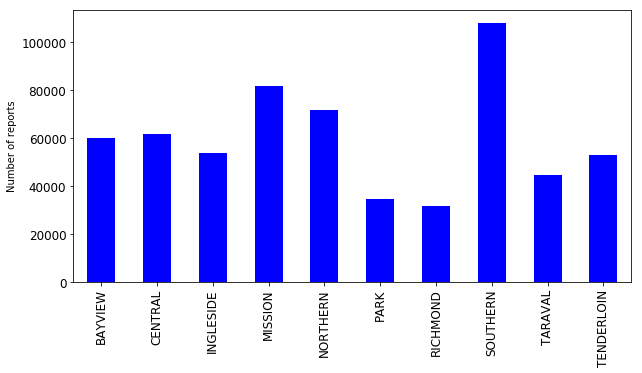

In [8]:
# Printing in bargraph function
plotdat(d_crime,'PdDistrict')

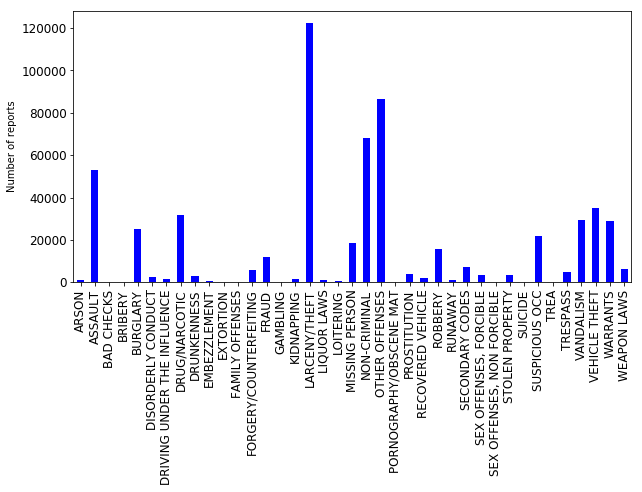

In [9]:
plotdat(d_crime,'Category')

In [10]:
# Grouping by description
l=d_crime.groupby('Descript').size()
l.sort_values()
print(l.shape)

(867,)


In [11]:
# Heatmap and hierarchical clustering
def types_districts(d_crime,per):
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

t=types_districts(d_crime,98)

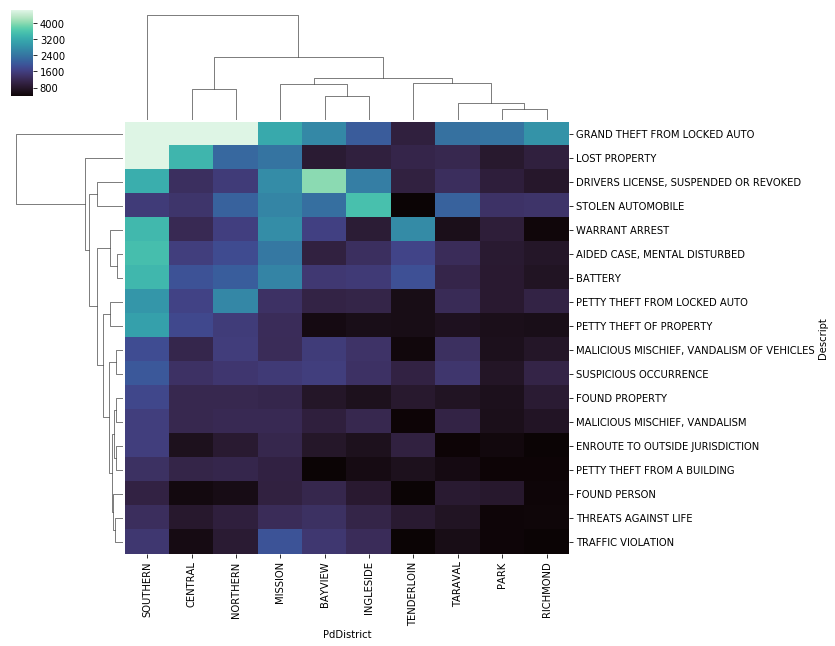

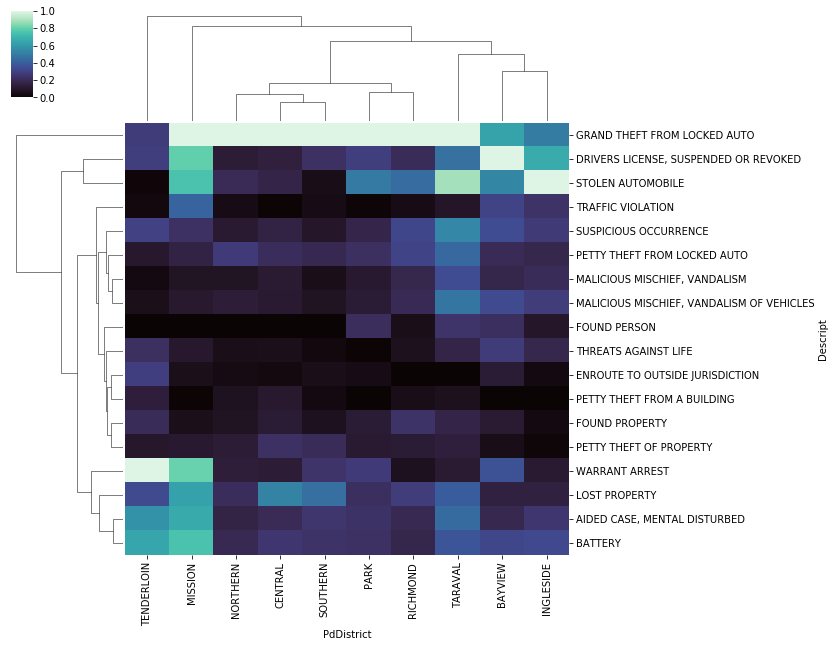

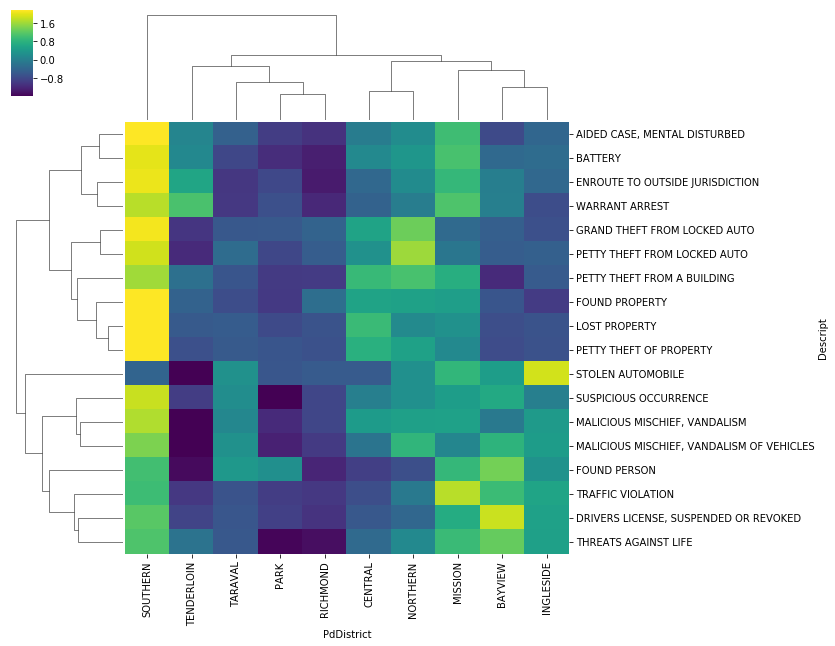

In [12]:
# Printing clustermap
sns.clustermap(t,cmap="mako", robust=True) 

sns.clustermap(t,standard_scale=1,cmap="mako", robust=True)

sns.clustermap(t,z_score=0,cmap="viridis", robust=True)

In [13]:
### 3. MONGO DATABASE CONNECTION AND LOAD ###

In [14]:
## (For me) First, it's needed to connect Mongo on a terminal window. I have to activate the server "mongod".
# Connecting to MongoDB
print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.test
collection = db.crimesf 


Mongo version 3.6.0


In [15]:
# Clean collection
collection.drop()

In [16]:
#Import data into the database. First, transform to JSON records
records = json.loads(d_crime.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)

In [17]:
# Stablish a pipeline to select all rows matching attribute "Category" = "ASSAULT"
pipeline = [
        {"$match": {"Category":"ASSAULT"}},
]

In [18]:
# Query the collection with the pipeline filter. 
aggResult = collection.aggregate(pipeline)
df2 = pd.DataFrame(list(aggResult))
df2.head()

,Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,Resolution,Time,X,Y,_id,days
0,300 Block of LEAVENWORTH ST,ASSAULT,02/01/2015 12:00:00 AM,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,NONE,15:45,-122.414406,37.784191,5a5f040a825f8507206cd817,4414.0
1,PACIFIC AV / GRANT AV,ASSAULT,02/01/2015 12:00:00 AM,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098414,"(37.7969028838908, -122.406831986427)",CENTRAL,"ARREST, BOOKED",17:05,-122.406832,37.796903,5a5f040a825f8507206cd82b,4414.0
2,PACIFIC AV / GRANT AV,ASSAULT,02/01/2015 12:00:00 AM,Sunday,BATTERY WITH SERIOUS INJURIES,150098414,"(37.7969028838908, -122.406831986427)",CENTRAL,"ARREST, BOOKED",17:05,-122.406832,37.796903,5a5f040a825f8507206cd82c,4414.0
3,400 Block of ELLIS ST,ASSAULT,02/01/2015 12:00:00 AM,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098420,"(37.784696907904, -122.413609328985)",TENDERLOIN,"ARREST, BOOKED",17:10,-122.413609,37.784697,5a5f040a825f8507206cd82e,4414.0
4,2000 Block of MISSION ST,ASSAULT,02/01/2015 12:00:00 AM,Sunday,BATTERY OF A POLICE OFFICER,150098458,"(37.764228935718, -122.419520367886)",MISSION,"ARREST, BOOKED",16:56,-122.419520,37.764229,5a5f040a825f8507206cd832,4414.0


In [19]:
#How many rows the collection has?
collection.find({"Category":"ASSAULT"}).count()

53125

In [20]:
# Let's have a look on incidents' descriptions
c=df2['Descript'].value_counts()
c.sort_values(ascending=False)
c.head(10)


BATTERY                                          17764
THREATS AGAINST LIFE                              9267
INFLICT INJURY ON COHABITEE                       4932
AGGRAVATED ASSAULT WITH A DEADLY WEAPON           4510
AGGRAVATED ASSAULT WITH BODILY FORCE              3639
BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP     2708
AGGRAVATED ASSAULT WITH A KNIFE                   1734
CHILD ABUSE (PHYSICAL)                             980
BATTERY OF A POLICE OFFICER                        900
BATTERY WITH SERIOUS INJURIES                      747
Name: Descript, dtype: int64

In [21]:
# Organize incidents' descriptions versus Districts where they were detected
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').PdDistrict.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t

In [22]:
# Filter outliers up to 75 percentile
t=types_districts(df2,75)

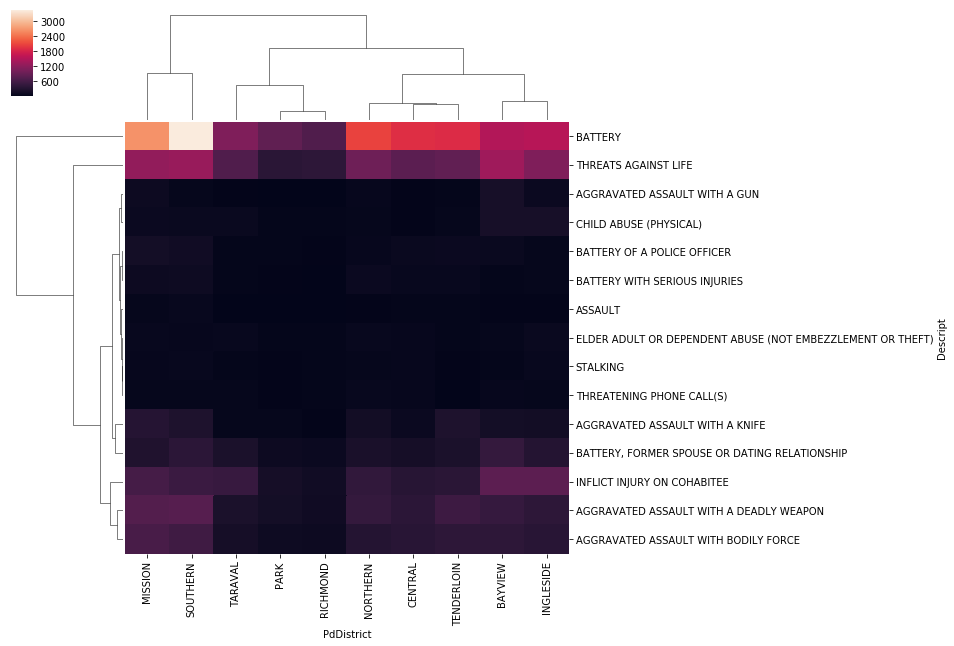

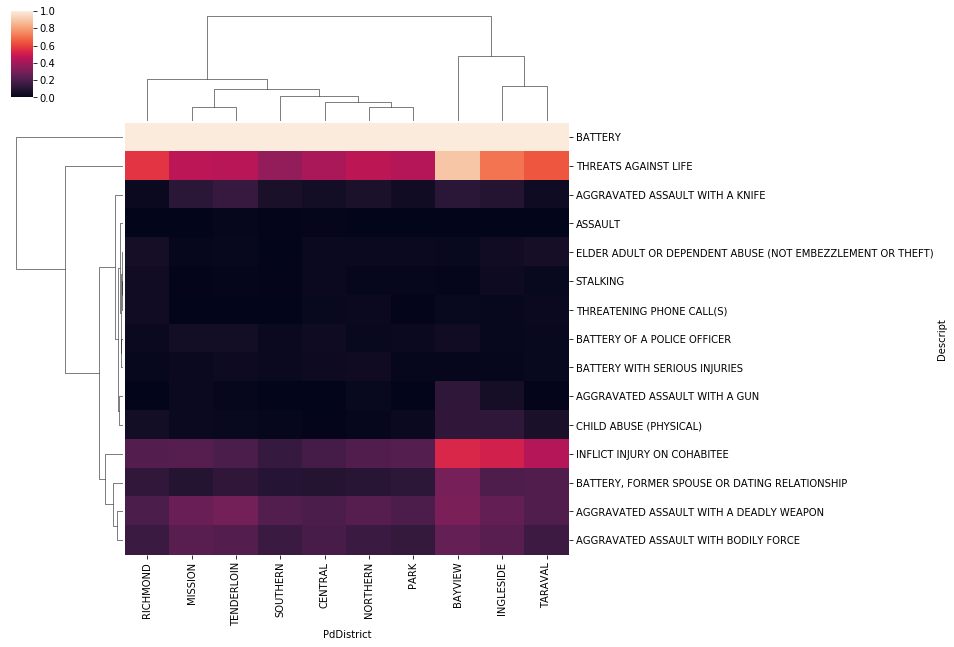

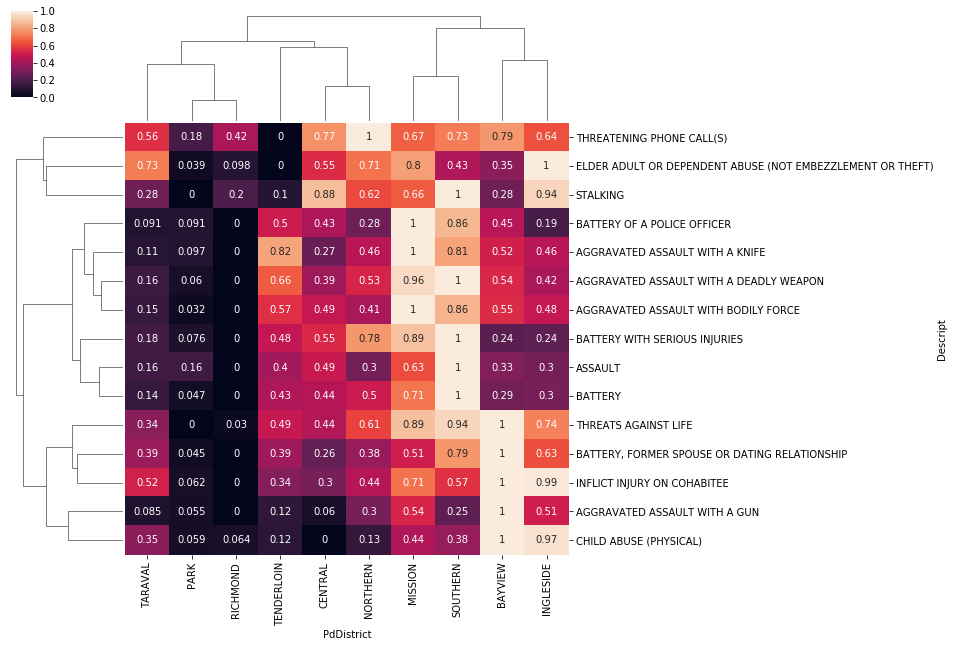

In [23]:
# Inspect data by means of clustermaps
sns.clustermap(t)
sns.clustermap(t,standard_scale=1)
sns.clustermap(t,standard_scale=0, annot=True)

In [24]:
### 4. TIME SERIES ANALYSIS ###

In [25]:
# Bin crime by 30 day window. That is, obtain new colum with corresponding months 
df2['Month']=np.floor(df2['days']/30) # Approximate month (30 day window)


In [26]:
# Time series function
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').Descript.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
  
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    
    return t

t_all=timeseries(df2,10)

In [27]:
# Find incidents descriptions related to word patter "AGGRAVATED"
pat = re.compile(r'BATTERY', re.I)

pipeline = [
        {"$match": {"Category":"ASSAULT" , 'Descript': {'$regex': pat}}},
]

aggResult = collection.aggregate(pipeline)
df3 = pd.DataFrame(list(aggResult))
df3.head()

battery = df3.groupby('Descript').size()
s = pd.Series(battery)
print(s)

s = s[s != 1]
battery_features = list(s.index)
print(battery_features)


Descript
BATTERY                                          17764
BATTERY DURING LABOR DISPUTE                         4
BATTERY OF A POLICE OFFICER                        900
BATTERY WITH SERIOUS INJURIES                      747
BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP     2708
dtype: int64
['BATTERY', 'BATTERY DURING LABOR DISPUTE', 'BATTERY OF A POLICE OFFICER', 'BATTERY WITH SERIOUS INJURIES', 'BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP']


In [28]:
#Let's generate a function to construct subsets of descriptions according to patterns: .
def descriptionsAccordingToPattern(pattern):
    pat = re.compile(pattern, re.I)
   
    pipeline = [
            {"$match": {"Category":"ASSAULT" , 'Descript': {'$regex': pat}}},
    ]
    
    aggResult = collection.aggregate(pipeline)
    df3 = pd.DataFrame(list(aggResult))
    inj = df3.groupby('Descript').size()
    s = pd.Series(inj)
    s = s[s != 1] # filter those descriptions with value less equal 1
    features = list(s.index)
    
    return features

In [29]:
# Trying the function with injury involved in the assault crime
injury_features = descriptionsAccordingToPattern('INJUR')

In [30]:
# Filtering by pattern "injur":
print(injury_features)

['BATTERY WITH SERIOUS INJURIES', 'CHILD, INFLICTING INJURY RESULTING IN TRAUMATIC CONDITION', 'CIVIL RIGHTS, INCL. INJURY, THREAT, OR DAMAGE (HATE CRIMES)', 'INFLICT INJURY ON COHABITEE', 'RESISTING PEACE OFFICER, CAUSING THEIR SERIOUS INJURY OR DEATH']


In [31]:
# Battery situations involved in the assault crime
labor_features = descriptionsAccordingToPattern('LABOR')
police_features = descriptionsAccordingToPattern('POLICE')
injuries_features = descriptionsAccordingToPattern('INJURIES')
dating_features = descriptionsAccordingToPattern('DATING')

In [32]:
# real dates for plotting
days_from_start=pd.Series(t_all.index*30).astype('timedelta64[D]')
dates_for_plot=date.min()+days_from_start
time_labels=dates_for_plot.map(lambda x: str(x.year)+'-'+str(x.month))

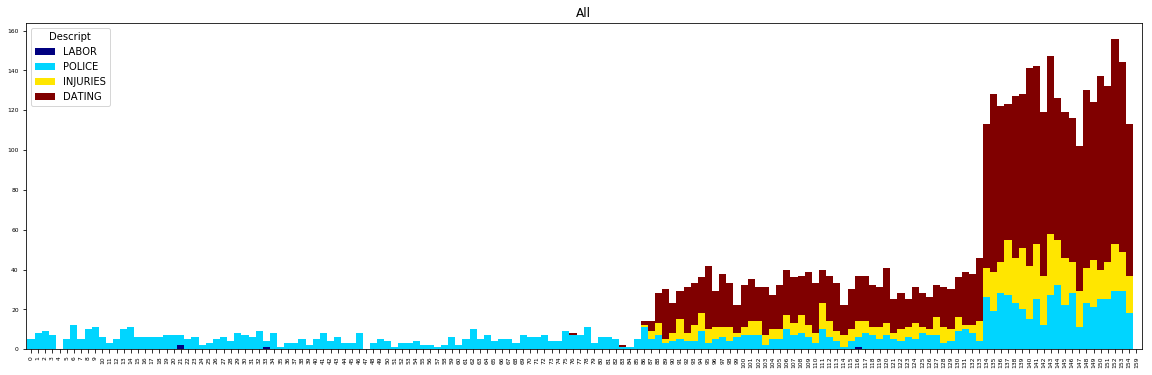

In [34]:
# Analytics per situation according to descriptions
district = 'All'

def situation_analysis(t,district,plot):
    t['LABOR']=t[labor_features].sum(axis=1)
    t['POLICE']=t[police_features].sum(axis=1)
    t['INJURIES']=t[injuries_features].sum(axis=1)
    t['DATING']=t[dating_features].sum(axis=1)

    situation=t[['LABOR','POLICE','INJURIES', 'DATING']]
    if plot:
        situation.index=[int(i) for i in situation.index]
        colors = plt.cm.jet(np.linspace(0, 1, situation.shape[1]))
        situation.plot(kind='bar', stacked=True, figsize=(20,6), color=colors, width=1, title=district,fontsize=6)
    return situation

situation_df_all=situation_analysis(t_all,district,True)

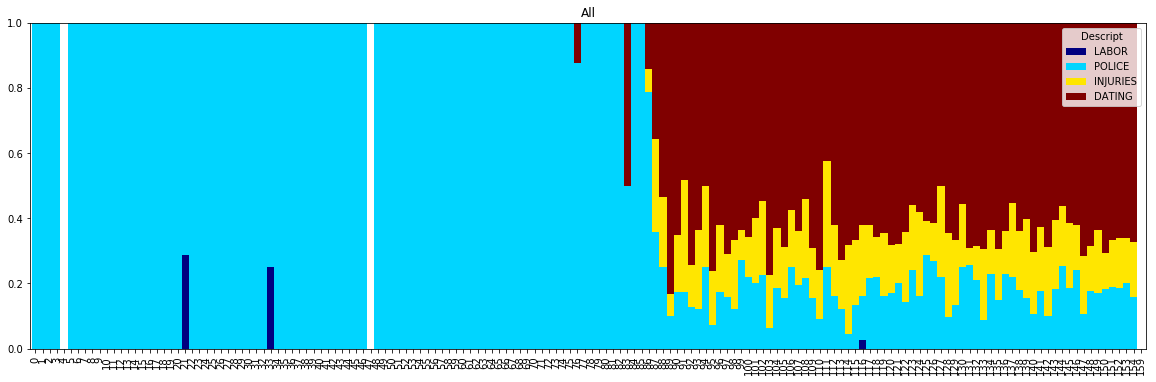

In [35]:
def situation_analysis_rescale(t,district,plot):
    t['LABOR']=t[labor_features].sum(axis=1)
    t['POLICE']=t[police_features].sum(axis=1)
    t['INJURIES']=t[injuries_features].sum(axis=1)
    t['DATING']=t[dating_features].sum(axis=1)

    situation=t[['LABOR','POLICE','INJURIES', 'DATING']]
    if plot:
        situation=situation.div(situation.sum(axis=1),axis=0)
        situation.index=[int(i) for i in situation.index]
        colors = plt.cm.GnBu(np.linspace(0, 1, situation.shape[1]))
        colors = plt.cm.jet(np.linspace(0, 1, situation.shape[1]))
        situation.plot(kind='bar', stacked=True, figsize=(20,6), color=colors, width=1, title=district, legend=True)
        plt.ylim([0,1])
    return situation

situation_df_all=situation_analysis_rescale(t_all,district,True)

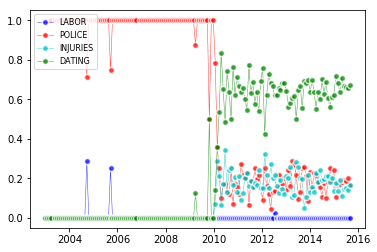

In [36]:
# Adding real dates and focusing
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['LABOR','POLICE','INJURIES','DATING'],['b','r','c','g']):
    plt.plot(dates_for_plot.index,situation_df_all[d],'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

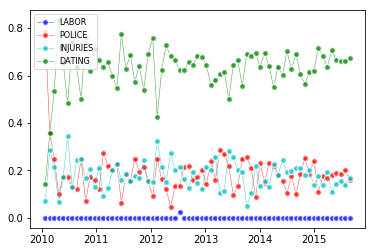

In [37]:
# filtering outliers until 2010
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['LABOR','POLICE','INJURIES','DATING'],['b','r','c','g']):
    plt.plot(dates_for_plot.tail(70).index,situation_df_all[d].tail(70),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})


In [40]:
# It's difficult and nonsense to stablish relationships between these categories selected. To do it right, it would have been better to chose another crime category rather than "assault". For the purpose of the exercise I will go on anyway. 

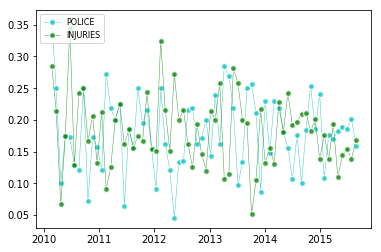

In [39]:
# So, let's going to examine possible correlation between POLICE and INJURIES caused
dates_for_plot.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (25.5,5.5)})
for d,c in zip(['POLICE','INJURIES'],['c','g']):
    plt.plot(dates_for_plot.tail(69).index,situation_df_all[d].tail(69),'o-',color=c,ms=6,mew=1.5,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

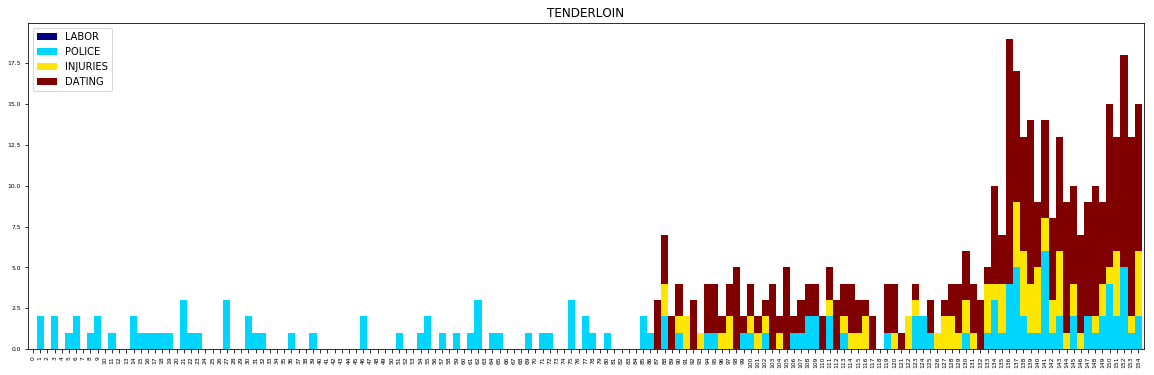

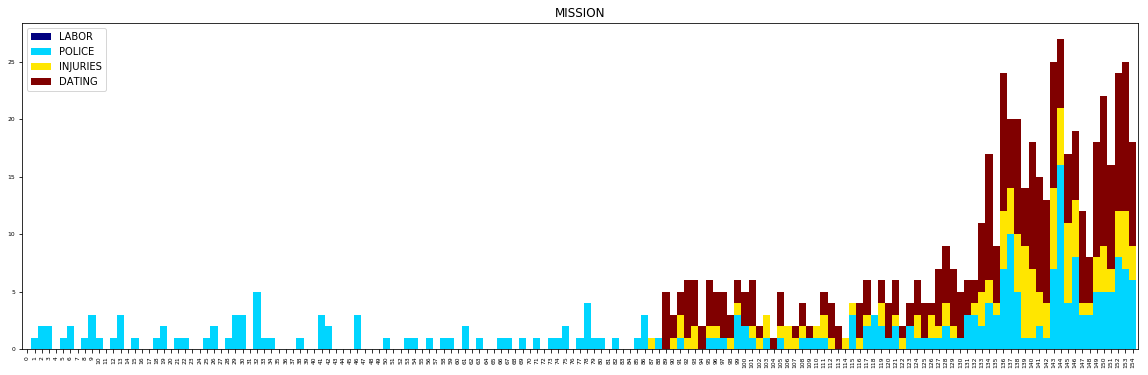

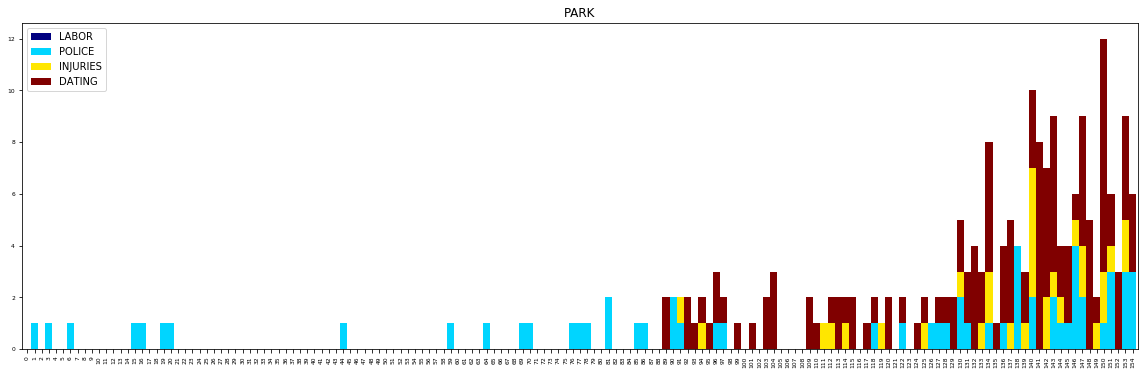

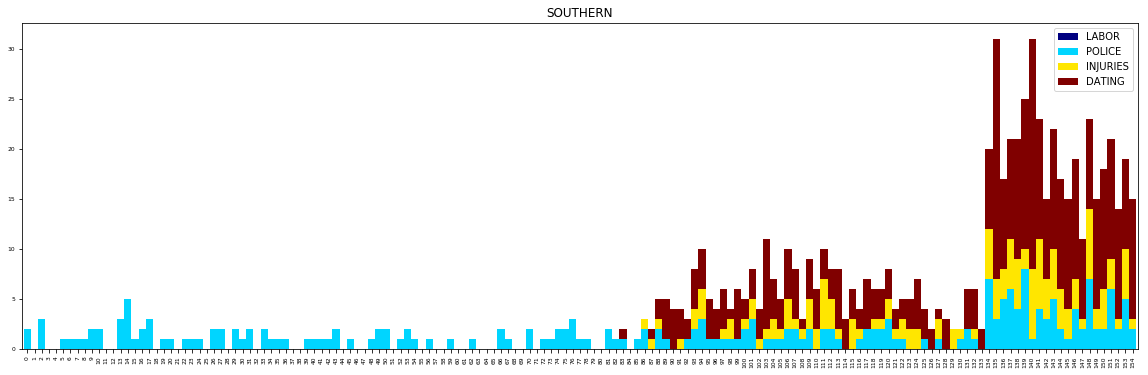

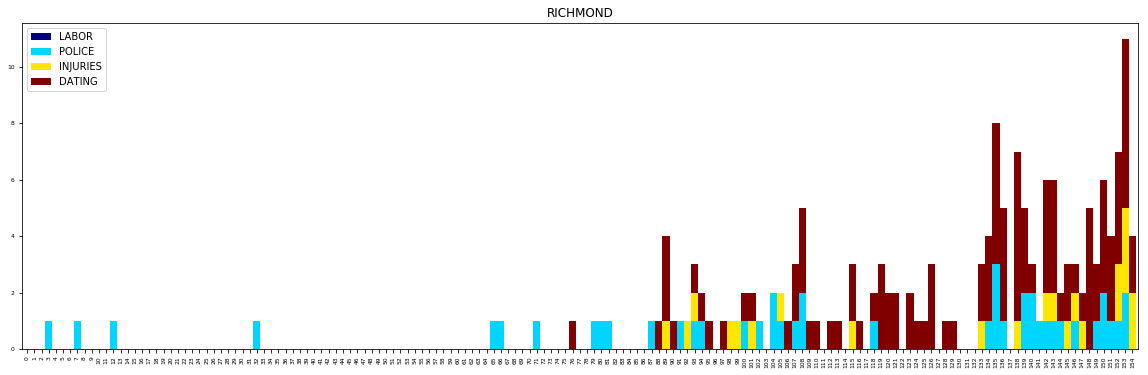

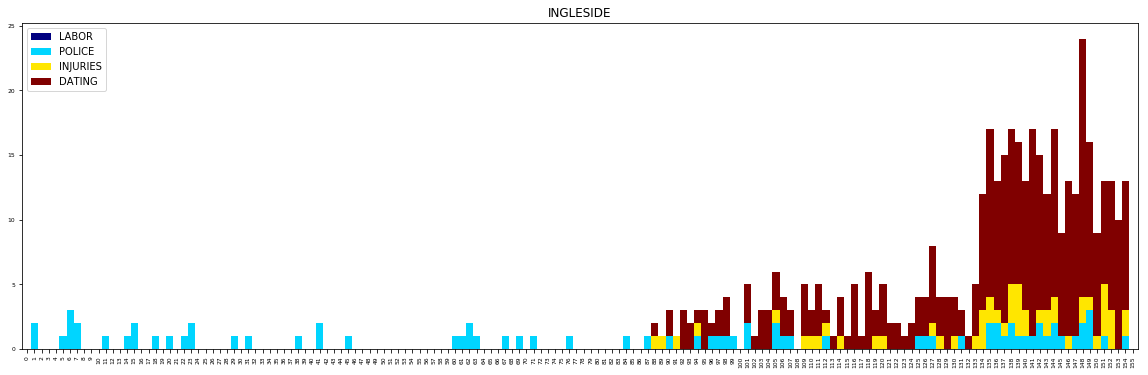

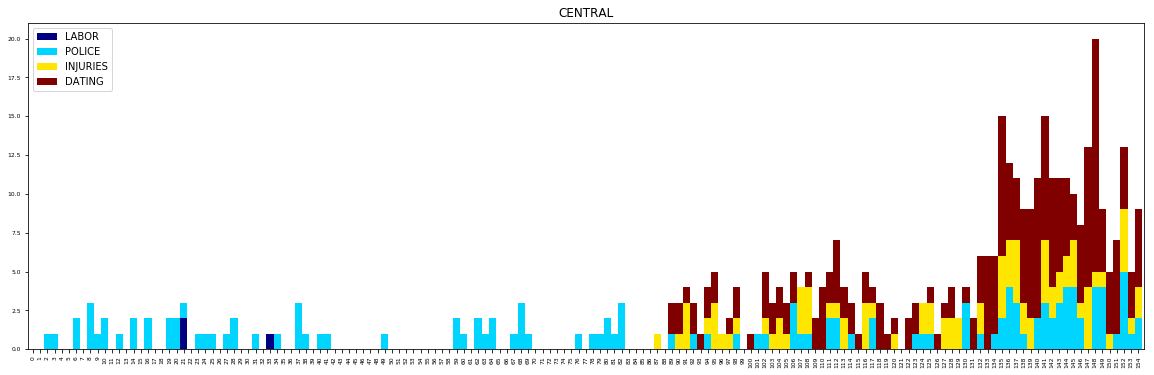

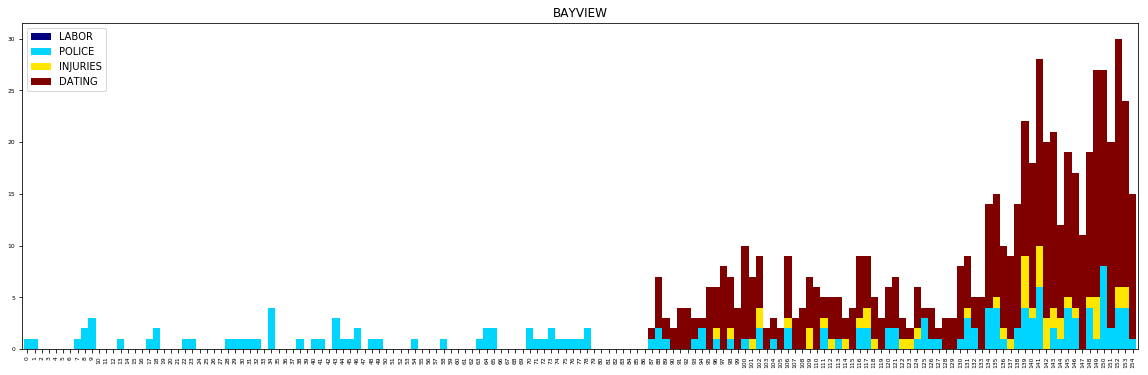

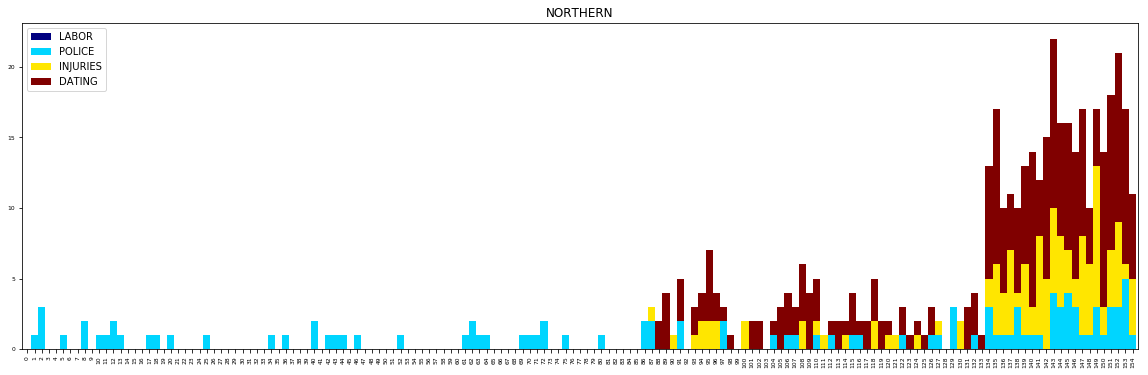

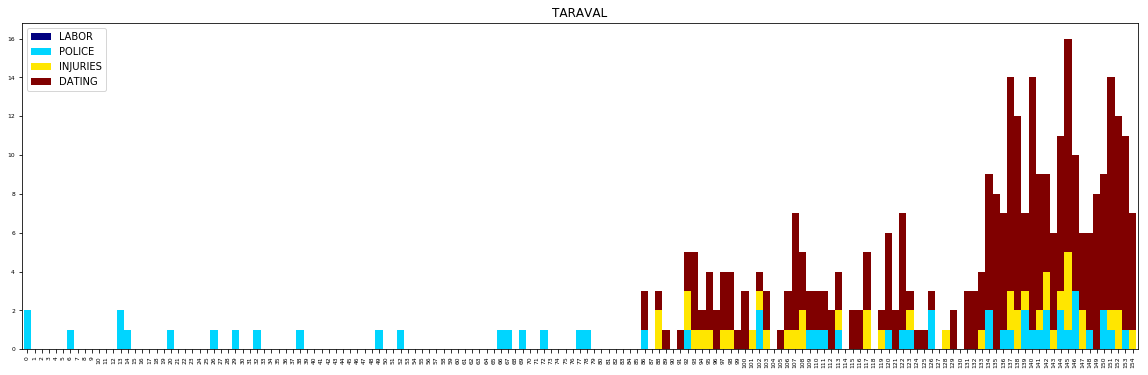

In [41]:
# Iterating through each district
stor=[]
stor_time=[]

for d in set(d_crime['PdDistrict']):
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    situation_df=situation_analysis(m,d,True)
    plt.show()
    s=situation_df.sum(axis=0)
    stor=stor+[s]
    situation_df.columns=cols=[c+"_%s"%d for c in situation_df.columns]
    stor_time=stor_time+[situation_df]
    
situation_dat_time=pd.concat(stor_time,axis=1)
situation_dat=pd.concat(stor,axis=1)
situation_dat.columns=[list(set(d_crime['PdDistrict']))]

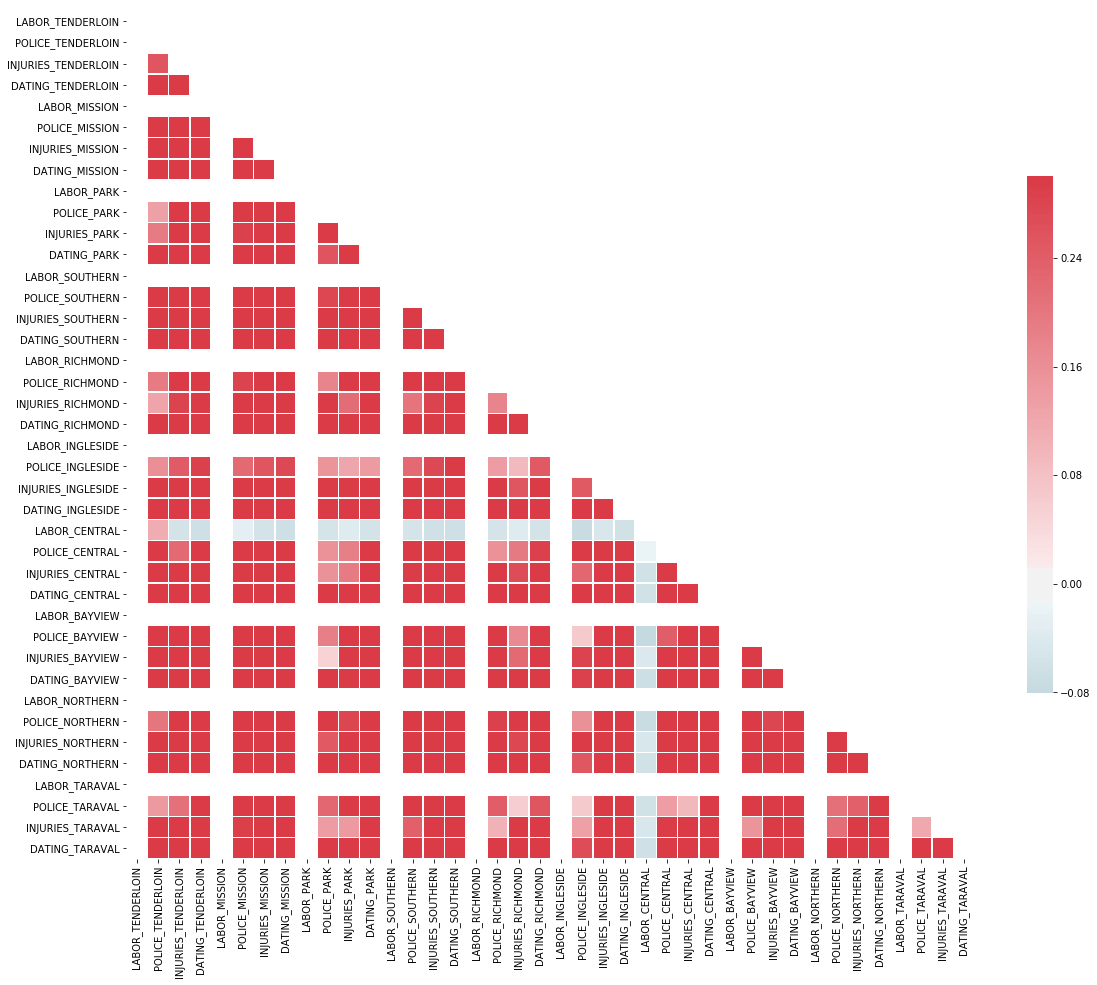

In [42]:
# Correlation Analysis
# Looking at correlations between areas for different drugs.
sns.set_context(rc={"figure.figsize": (20,20)})
corr = situation_dat_time.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 19))

# Generate a custom diverging colormap
sns.set_context(rc={"figure.figsize": (20,20)})
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(corr,  mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

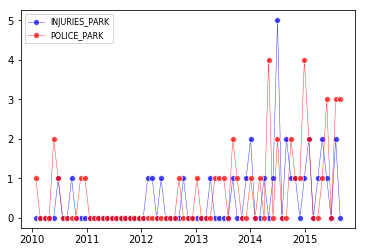

In [44]:
# Inquiring in "Injuries" and "Police" in Park. Filtering from 2010 onwards
situation_dat_time.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['INJURIES_PARK','POLICE_PARK'],['b','r']):
    plt.plot(situation_dat_time.tail(70).index,situation_dat_time[d].tail(70),'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

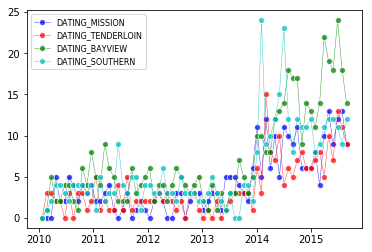

In [45]:
# Comparing dating or former spouse relationships situation in batteries assault in different districts and filtering to show from 2010 onwards
situation_dat_time.index=dates_for_plot
sns.set_context(rc={"figure.figsize": (7.5,5)})
for d,c in zip(['DATING_MISSION','DATING_TENDERLOIN','DATING_BAYVIEW','DATING_SOUTHERN'],['b','r','g','c']):
    plt.plot(situation_dat_time.tail(70).index,situation_dat_time[d].tail(70),'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':8})

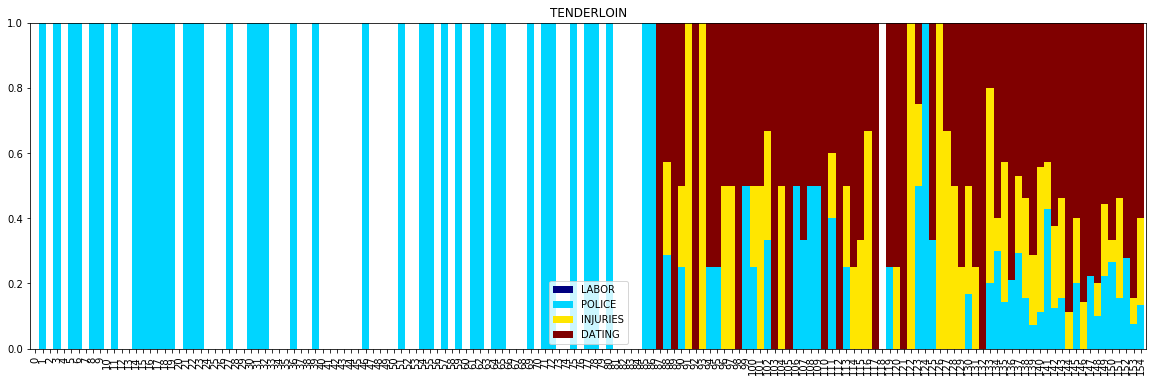

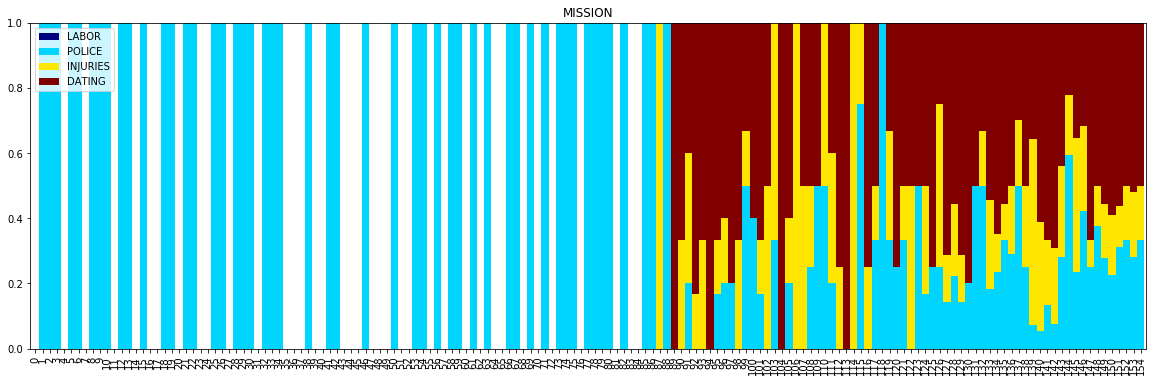

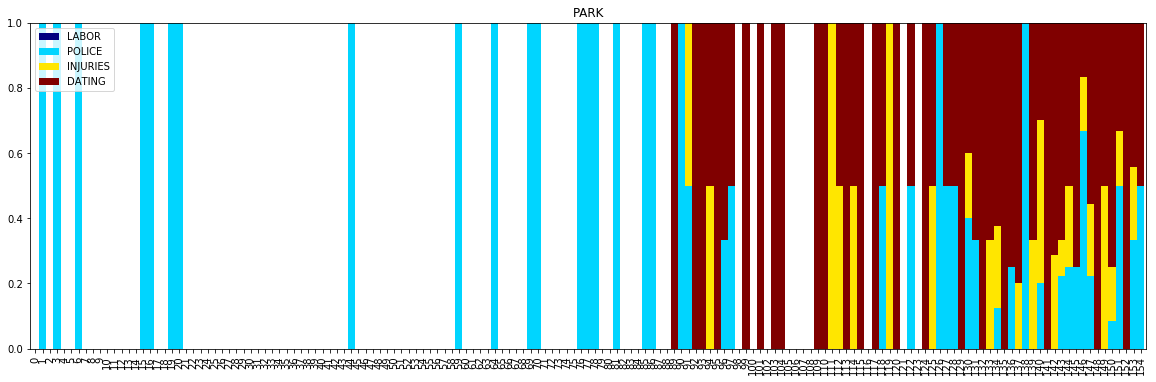

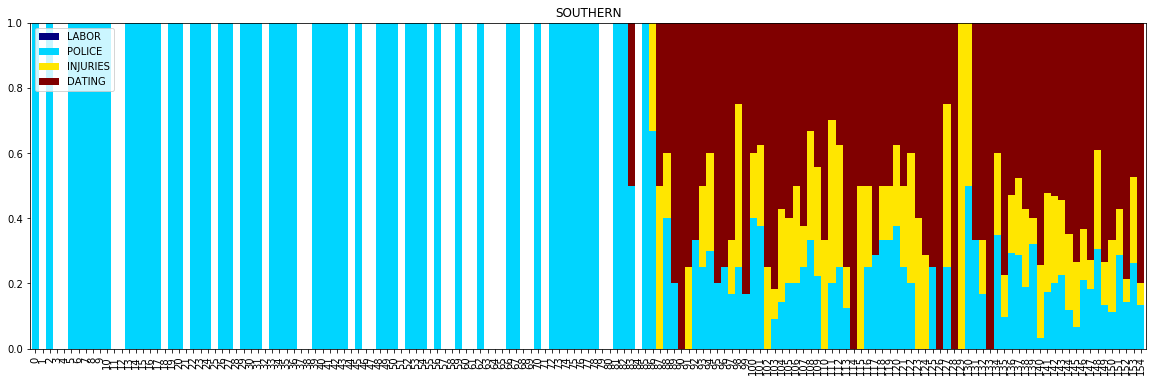

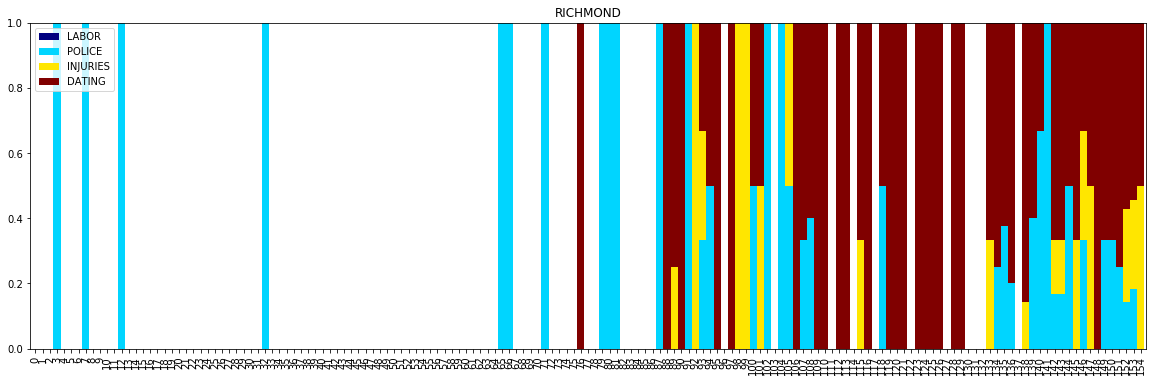

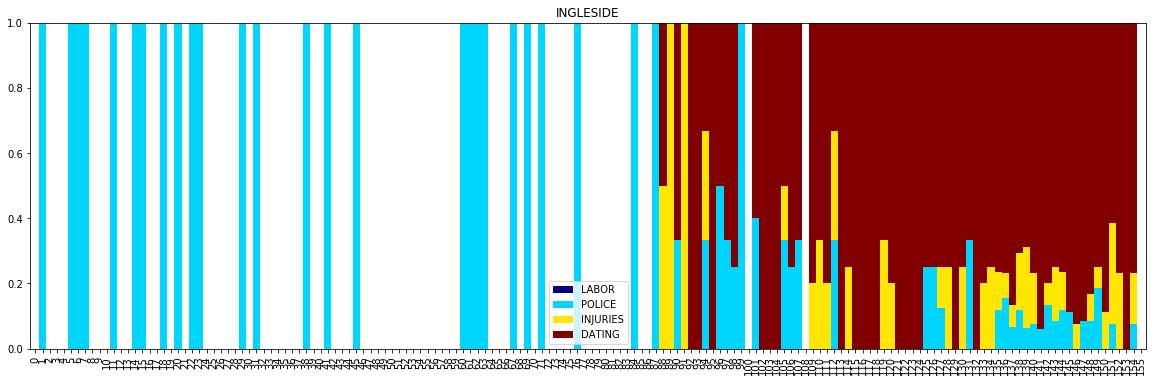

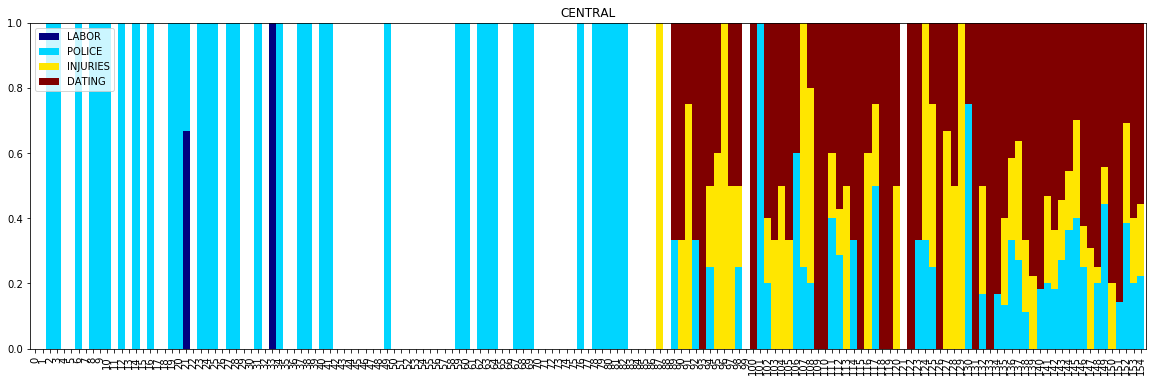

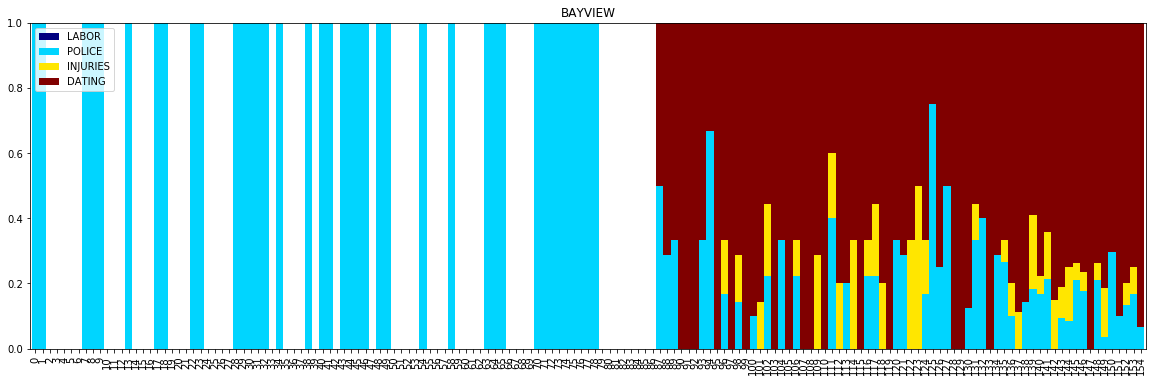

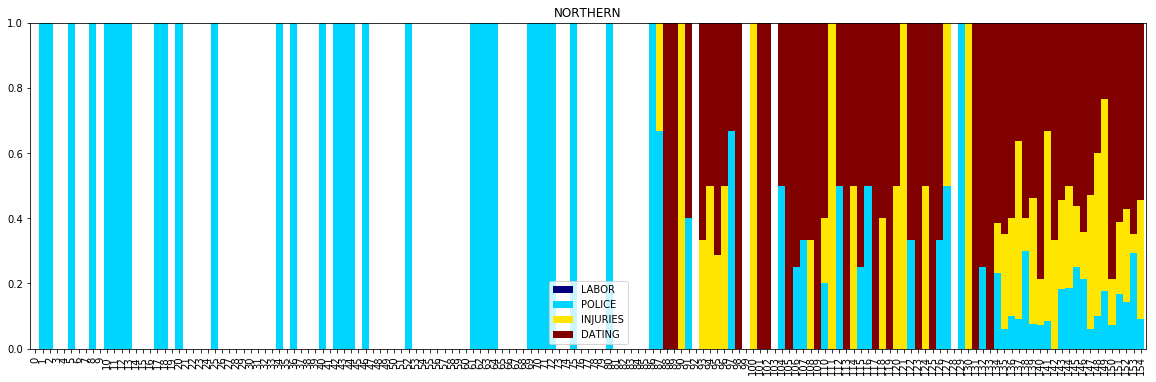

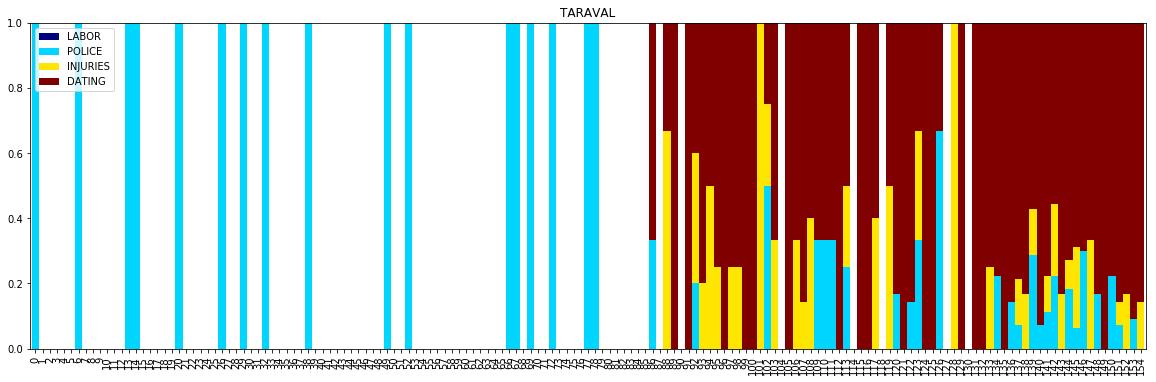

In [46]:
#Re-scaling everything we have done

stor=[]
stor_time=[]

for d in set(d_crime['PdDistrict']):
    # Specify district and group by time
    dist_dat=df2[df2['PdDistrict']==d]
    t=timeseries(dist_dat,0)
    # Merge to ensure all categories are preserved!
    t_merge=pd.DataFrame(columns=t_all.columns)
    m=pd.concat([t_merge,t],axis=0).fillna(0)
    m.reset_index(inplace=True)
    # Plot
    sit_df=situation_analysis_rescale(m,d,True)
    plt.show()
    s=sit_df.sum(axis=0)
    stor=stor+[s]
    sit_df.columns=cols=[c+"_%s"%d for c in sit_df.columns]
    stor_time=stor_time+[sit_df]
    
sit_dat_time_rescale=pd.concat(stor_time,axis=1)
sit_dat_rescale=pd.concat(stor,axis=1)
situation_dat.columns=[list(set(d_crime['PdDistrict']))]

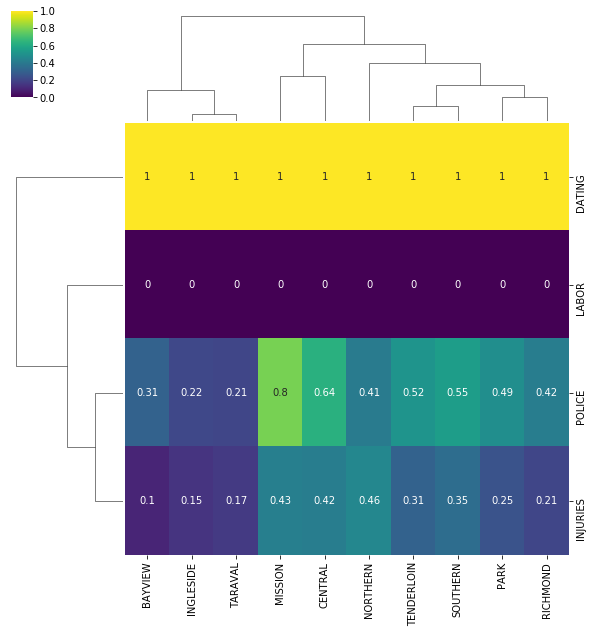

In [47]:
# Summarizing in a heatmap
sns.clustermap(situation_dat,standard_scale=1,cmap="viridis",robust=True,annot=True)


In [48]:
# 6. MAPPING RELATIONSHIPS

In [49]:
# Isolating police related records
tmp=df2.copy()
tmp.set_index('Descript',inplace=True)

police_dat=tmp.loc[police_features]
police_pts=police_dat[['X','Y','Month']]

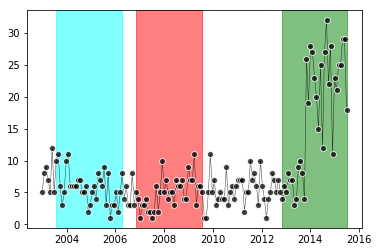

In [52]:
# Plotting the police regimes.

d=pd.DataFrame(police_pts.groupby('Month').size())
d.index=dates_for_plot.head(153)
d.columns=['Count']

diff=len(d.index)-120

plt.plot(d.index,d['Count'],'o-',color='k',ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.axvspan(d.index[40-diff],d.index[40],color='cyan',alpha=0.5)
plt.axvspan(d.index[80-diff],d.index[80],color='red',alpha=0.5)
plt.axvspan(d.index[120],d.index[-1],color='green',alpha=0.5)

In [53]:
# Stablishing new and old regimes.
oldest_police_sums=d.loc[(d.index>d.index[40-diff]) & (d.index<d.index[40])]
old_police_sums=d.loc[(d.index>d.index[80-diff]) & (d.index<d.index[80])]
new_police_sums=d.loc[d.index>d.index[120]]

old_police_sums['Count'].mean()/float(new_police_sums['Count'].mean())

oldest_police=police_pts[(police_pts['Month']>(40-diff)) & (police_pts['Month']<40)]
oldest_police.columns=['longitude','latitude','time']
old_police=police_pts[(police_pts['Month']>(80-diff)) & (police_pts['Month']<80)]
old_police.columns=['longitude','latitude','time']
new_police=police_pts[police_pts['Month']>120]
new_police.columns=['longitude','latitude','time']

In [54]:
# Showing on a map using https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h

In [55]:
# Let's create MongoBD collections to manage and query data
col1 = db.policeo
col2 = db.policen

In [56]:
#Import data into the database
col1.drop()
col2.drop()

In [57]:
# Collection for new police assaults records
data_json1 = json.loads(new_police.to_json(orient='records'))
col1.delete_many({})
col1.insert_many(data_json1)

In [58]:
# Collection for old police assaults records
data_json2 = json.loads(old_police.to_json(orient='records'))
col2.delete_many({})
col2.insert_many(data_json2)

In [59]:
#Checking access from MongoDB.
cursor = col1.find().sort('time',pymongo.ASCENDING).limit(3)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5a5f1c0a825f8507207601cf'), 'longitude': -122.3905779773, 'latitude': 37.7342439949, 'time': 121.0}
{'_id': ObjectId('5a5f1c0a825f8507207601de'), 'longitude': -122.4073871721, 'latitude': 37.7810688919, 'time': 121.0}
{'_id': ObjectId('5a5f1c0a825f8507207601e6'), 'longitude': -122.3878336523, 'latitude': 37.7131072321, 'time': 121.0}


In [60]:
cursor2 = col2.find().sort('time',pymongo.ASCENDING).limit(10)
for doc in cursor2:
    print(doc)

{'_id': ObjectId('5a5f1c17825f850720760218'), 'longitude': -122.4831658183, 'latitude': 37.7567333083, 'time': 48.0}
{'_id': ObjectId('5a5f1c17825f85072076024b'), 'longitude': -122.3910903256, 'latitude': 37.7369085657, 'time': 48.0}
{'_id': ObjectId('5a5f1c17825f850720760283'), 'longitude': -122.4125153414, 'latitude': 37.7804777481, 'time': 48.0}
{'_id': ObjectId('5a5f1c17825f85072076024d'), 'longitude': -122.4050654831, 'latitude': 37.7980134745, 'time': 49.0}
{'_id': ObjectId('5a5f1c17825f850720760278'), 'longitude': -122.4143601388, 'latitude': 37.7764301694, 'time': 49.0}
{'_id': ObjectId('5a5f1c17825f85072076028c'), 'longitude': -122.4051181972, 'latitude': 37.7746534767, 'time': 49.0}
{'_id': ObjectId('5a5f1c17825f850720760294'), 'longitude': -122.4811831716, 'latitude': 37.743726817, 'time': 49.0}
{'_id': ObjectId('5a5f1c17825f85072076029a'), 'longitude': -122.3843968711, 'latitude': 37.7325070966, 'time': 49.0}
{'_id': ObjectId('5a5f1c17825f85072076021b'), 'longitude': -122.4

In [61]:
# Create a new collection to store districts geo points
col3 = db.districts
col3.drop()


In [86]:
# mongoBD import from geojson file containing geopoints in form of multipopygons
os.system('"C:\\Program Files\\MongoDB\\Server\\3.6\\bin\\mongoimport" -d test -c districts --file C:\\Users\\Alvaro\\Downloads\\Analysis_Neighborhoods.geojson')

0

In [87]:
# Checking data imported
cursor3 = col3.find().limit(1)
for doc in cursor3:
    print(doc)
    

{'_id': ObjectId('5a5f1f3a6b413b4b0ee13279'), 'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'nhood': 'Bayview Hunters Point'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.38157774241415, 37.75307043091241], [-122.38156949251606, 37.753060959298274], [-122.38159239626694, 37.75309424492931], [-122.38155614326205, 37.753045901366754], [-122.38155137472305, 37.75304127677009], [-122.38154650687193, 37.753036719547374], [-122.3815415385967, 37.75303223061754], [-122.38153647334677, 37.75302781172802], [-122.38153131112232, 37.75302346287867], [-122.38152605423795, 37.753019185835115], [-122.38152070389688, 37.75301498328154], [-122.38151526236827, 37.75301085518192], [-122.38150973196667, 37.75300680330162], [-122.38150411158058, 37.75300282855954], [-122.38149840577098, 37.7529989317842], [-122.38149261460651, 37.75299511567804], [-122.38148674033339, 37.75299137930393], [-122.38148078528907, 37.75298772532827], [-122.38147475063121, 37.7529

In [88]:
# Get information about the index
col2.index_information()

{'_id_': {'key': [('_id', 1)], 'ns': 'test.policen', 'v': 2}}

In [89]:
col_temp = db.policen2
cursor = col2.find()
for doc in cursor:
    col_temp.insert_one({
        "loc": {
            "type": "Point",
            "coordinates": [doc["longitude"], doc["latitude"]]
        }
    });

In [90]:
cursor = col_temp.find().limit(10)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5a5f16d5825f851bc8936daf'), 'loc': {'type': 'Point', 'coordinates': [-122.4172733449, 37.7861493948]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db0'), 'loc': {'type': 'Point', 'coordinates': [-122.4415129912, 37.7845714031]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db1'), 'loc': {'type': 'Point', 'coordinates': [-122.4296443876, 37.7628747193]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db2'), 'loc': {'type': 'Point', 'coordinates': [-122.3971410368, 37.7972432335]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db3'), 'loc': {'type': 'Point', 'coordinates': [-122.4961530371, 37.7589779856]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db4'), 'loc': {'type': 'Point', 'coordinates': [-122.412999075, 37.7862774592]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db5'), 'loc': {'type': 'Point', 'coordinates': [-122.4170853574, 37.785215359]}}
{'_id': ObjectId('5a5f16d5825f851bc8936db6'), 'loc': {'type': 'Point', 'coordinates': [-122.4243413624, 37.7919651856]}}
{'_id': ObjectId('5a5f16d5825f851b

In [91]:
cursor2 = col2.find_one()   


In [92]:
query = {"features.geometry": 
    { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [93]:
cursor3 = col3.find_one(query)

In [94]:
# Generate new collection with features filteres
collection_features = db.feat
collection_features.delete_many({})
collection_features.insert_many(cursor3['features'])

In [95]:
# Obtain cursor
cursor4 = collection_features.find_one()

In [96]:
# Spatial query implementing getoIntersects operation
query_feat = {"geometry": 
                { "$geoIntersects": 
                { "$geometry": 
                    {"type": "Point", 
                     "coordinates": [cursor2["longitude"],cursor2["latitude"]] 
                    }
                } 
            } 
        }

In [97]:
# Checking everything is ok
for doc in collection_features.find(query_feat):
    print(doc)

{'_id': ObjectId('5a5f1f5e825f8507207603f8'), 'type': 'Feature', 'properties': {'nhood': 'Tenderloin'}, 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-122.41916799985066, 37.77527799990682], [-122.41925600041813, 37.77514700013959], [-122.41935500006726, 37.77523399961008], [-122.41939699952106, 37.77542200004141], [-122.41949200013437, 37.77589399961393], [-122.41956499957605, 37.77626199999847], [-122.41950599973194, 37.77636899968392], [-122.41960300047128, 37.77645700031401], [-122.41974999944436, 37.77719200043556], [-122.4196939997964, 37.777300000350024], [-122.41978800014282, 37.77738699977687], [-122.41985700054809, 37.777732000207614], [-122.41993399959553, 37.778119999861445], [-122.4198829995938, 37.778251000384664], [-122.41996799963695, 37.77831200014394], [-122.42031100036978, 37.77991699975996], [-122.42024699960035, 37.78007499991484], [-122.42033599968612, 37.78019000006485], [-122.42042499996765, 37.78058300024146], [-122.42049900049216, 37.78090900040971],

In [98]:
# Obtain the selected neighborhood
cursor_feat = collection_features.find_one(query_feat)
print(cursor_feat["properties"])

{'nhood': 'Tenderloin'}


In [101]:
# Set general coordinates of San Francisco city
SF_COORDINATES = (37.76, -122.45)

MAX_RECORDS = 100

m = folium.Map(location=SF_COORDINATES, zoom_start=12)

geo_json_data = json.load(open('C:\\Users\\Alvaro\\Downloads\\Analysis_Neighborhoods.geojson'))
folium.GeoJson(geo_json_data).add_to(m)

In [102]:
# Display Old Police assault records (Red)
cursor = col1.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='Old Police Assault',
                  icon=folium.Icon(color='red')).add_to(m)

In [103]:
# Display New Police assault records (Green)
cursor = col2.find().limit(MAX_RECORDS)
for doc in cursor:
    folium.Marker(location = [doc["latitude"],doc["longitude"]],
                  popup='New Police Assault',
                  icon=folium.Icon(color='green')).add_to(m)

In [104]:
# Display queried point in spatial query (Blue)
folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(m)

In [105]:
folium.LayerControl().add_to(m)

In [106]:
# Saving map in a html archive
m.save(outfile='C:\\Users\\Alvaro\\Documents\\Modulo 5\\map1.html')

In [107]:
get_ipython().run_cell_magic('HTML', '', '<iframe width="100%" height="350" src="file:///C://Users//Alvaro//Documents//Module 5//map1.html?inline=true"></iframe>')

In [108]:
# Obtaining the geometry of an Incident
map2 = folium.Map(location=SF_COORDINATES, zoom_start=12)

folium.GeoJson(
    cursor_feat["geometry"],
    name='Selected Neighborhood'
).add_to(map2)

folium.Marker(location = [cursor2["latitude"],cursor2["longitude"]],
                  popup='Selected Point',
                  icon=folium.Icon(color='blue')).add_to(map2)

folium.LayerControl().add_to(map2)

In [109]:
# Saving map2 in a html archive
map2.save(outfile='C:\\Users\\Alvaro\\Documents\\Modulo 5\\map2.html')

In [110]:
map2